In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from dateutil.relativedelta import relativedelta
from metricas import calculo_metricas
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV


import warnings
warnings.simplefilter("ignore")

# Mostramos las versiones de los módulos para posibles reproducciones del código

print('Versión pandas:', pd.__version__)
print('Versión numpy:', np.__version__)
print('Versión matplotlib:', matplotlib.__version__)
print('Version statsmodels', sm.__version__)


Versión pandas: 1.0.5
Versión numpy: 1.19.5
Versión matplotlib: 3.2.2
Version statsmodels 0.12.2


In [2]:
df = pd.read_csv('Data/dataframe.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
df = df.drop(columns = ["Festivo_Regional", "Humedad_Relativa", "Precipitacion", "Radiacion", "Velocidad_Viento"])

df.loc[:, "lag_24"] = df.Spot_electricidad.shift(24)
df.loc[:, "lag_48"] = df.Spot_electricidad.shift(48)
df.loc[:, "lag_1_semana"] = df.Spot_electricidad.shift(24*7)

db = df.dropna()
X_train = db.copy()
y_train = X_train.pop('Spot_electricidad')

# Lasso

In [3]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

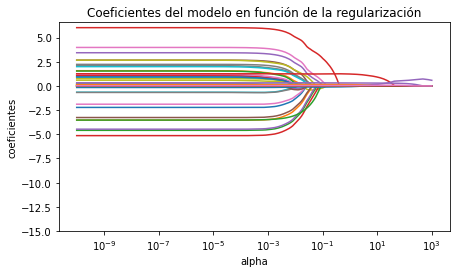

In [4]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

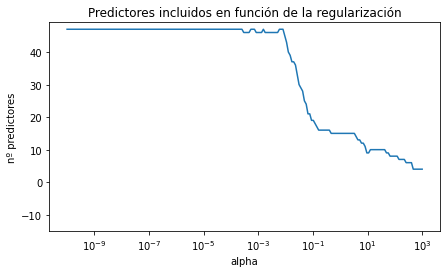

In [5]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

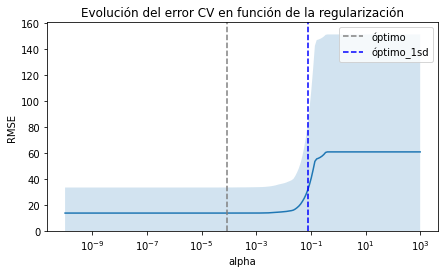

In [6]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();


In [7]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 8.804883581643464e-05


In [8]:
# Mejor valor alpha encontrado + 1sd
# ==============================================================================
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [0.07663411]


In [13]:
modelo = Lasso(alpha=optimo, normalize=True)
modelo.fit(X_train, y_train)

Lasso(alpha=8.804883581643464e-05, normalize=True)

In [14]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
1,Prevision_Eol_Fotov,-0.000734
2,Hueco_Termico,0.001138
3,Lunes,5.319960
4,Martes,2.584483
5,Miercoles,1.904783
6,Jueves,3.182367
7,Viernes,1.509622
8,Sabado,0.558978
9,Hora_1,0.361100
10,Hora_2,-0.777320


### Backtesting

In [25]:
def bascktesting_regresion_lineal(db, año, mes, rolling_window, days_start):
    fecha = datetime(año, mes, 1)
    fecha_str = str(año) + '-' + str(mes) + '-' + str(1)
    
    db = db.dropna()
    array_real, array_pred, array_date = np.zeros(len(db.loc[fecha_str:])), np.zeros(len(db.loc[fecha_str:])), []

    # En caso de que haya rolling window
    if rolling_window == True:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_start_train = fecha_end_train - relativedelta(days = days_start)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            fecha_start_train = str(fecha_start_train.year) + "-" + str(fecha_start_train.month) + "-" + str(fecha_start_train.day)
            db_aux = db.loc[fecha_start_train:fecha_end_train]
            
            # Dataframe de Entrenamiento
            X_train = db_aux.copy()
            y_train = X_train.pop('Spot_electricidad')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)

            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)

            # Entrenamos el model
            model = Lasso(alpha=optimo_1sd, normalize=True)
            model.fit(X_train, y_train)
            
            # Realizamos las predicciones
            pred = model.predict(X_test)
            date = X_test.index

            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred
            array_real[day*24:day*24 + 24] = y_test
    # En caso de que no haya rolling window, siempre cogemos todo el dataframe disponible
    else:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            db_aux = db.loc[:fecha_end_train]

            # Dataframe de Entrenamiento
            X_train = db_aux.copy()
            y_train = X_train.pop('Spot_electricidad')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)
            
            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)
            
            # Entrenamos el model
            model = Lasso(alpha=optimo, normalize=True)
            model.fit(X_train, y_train)
            
            # Realizamos las predicciones
            pred = model.predict(X_test)
            date = X_test.index

            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred
            array_real[day*24:day*24 + 24] = y_test
            print(day)
    array_date = [item for sublist in array_date for item in sublist]
    return array_pred, array_real, array_date
    
# pred, real, dates = bascktesting_regresion_lineal(db.loc["2019":"2021-04"], 2020, 1, rolling_window = True, days_start = 45)

### Backtesting rapido (con optimo)

In [24]:
for dias in [7, 14, 21, 30, 60, 90, 150, 220, 365]:
    print(dias)
    print("**********************************")
    pred, real, dates = bascktesting_regresion_lineal(db.loc["2020":], 2021, 1, rolling_window = True, days_start = dias)
    resultados = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
    resultados["Pred"][resultados.loc[:, "Pred"] < 0] = 0
    calculo_metricas(resultados)

7
**********************************
     MAE  MAE (median)   MAPE  WMAPE   RMSE  % Trend
0  17.73         10.01  93.12  15.84  30.96    82.51
14
**********************************
     MAE  MAE (median)   MAPE  WMAPE  RMSE  % Trend
0  24.86          13.8  72.53  22.21  42.2    83.25
21
**********************************
     MAE  MAE (median)  MAPE  WMAPE  RMSE  % Trend
0  15.58         10.17  75.6  13.92  24.2     84.5
30
**********************************
     MAE  MAE (median)   MAPE  WMAPE   RMSE  % Trend
0  12.41          8.29  97.97  11.09  19.61    84.95
60
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  10.86          7.43  118.47   9.71  16.97    85.47
90
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  10.52          7.27  113.81    9.4  16.56     85.4
150
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  10.54          7.13  132.89   9.42  16.74  

### Backtesting rapido (con optimo_1sd)

In [26]:
for dias in [7, 14, 21, 30, 60, 90, 150, 220, 365]:
    print(dias)
    print("**********************************")
    pred, real, dates = bascktesting_regresion_lineal(db.loc["2020":], 2021, 1, rolling_window = True, days_start = dias)
    resultados = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
    resultados["Pred"][resultados.loc[:, "Pred"] < 0] = 0
    calculo_metricas(resultados)

7
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  11.92          6.96  122.57  10.65  19.53    84.23
14
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  11.29          6.97  157.43  10.09  18.71    85.12
21
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  11.09          7.19  165.43   9.91  17.88    85.26
30
**********************************
     MAE  MAE (median)    MAPE  WMAPE  RMSE  % Trend
0  11.07          7.71  187.67   9.89  17.4    85.34
60
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  12.11          9.01  173.82  10.82  17.88    85.41
90
**********************************
     MAE  MAE (median)   MAPE  WMAPE   RMSE  % Trend
0  12.79          9.75  163.3  11.43  18.46    85.28
150
**********************************
     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  14.79         11.81  158.92  13.2

### Calculo de las métricas

In [25]:
resultados = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
resultados["Pred"][resultados.loc[:, "Pred"] < 0] = 0

def calculo_metricas(dataframe):
    dataframe.loc[:, "MAE"] = mae(dataframe.Pred, dataframe.Real)
    dataframe.loc[:, "MAPE"] = mape(dataframe.Pred, dataframe.Real)
    
    for metrica in ["MAE", "MAPE"]:
        if metrica == "MAE":
            print("Media ", metrica, "en el periodo:", round(float(dataframe.loc["2020-01":"2021-04"][[metrica]].mean()), 3), '€/MWh\nDesviacion estandar del ', metrica,':' ,round(float(dataframe.loc["2020-01":"2021-04"][[metrica]].std()), 3), "€/MWh\n")
        else:
            print("Media ", metrica, "en el periodo:", round(float(dataframe.loc["2020-01":"2021-04"][[metrica]].mean()), 3), '%\nDesviacion estandar del ', metrica,':' ,round(float(dataframe.loc["2020-01":"2021-04"][[metrica]].std()), 3), "%\n")
    
    print('El RMSE para el periodo es:', round(rmse(dataframe.Pred, dataframe.Real),3), "€/MWh")
    
    metricas_mensuales_dataframe = dataframe.loc["2020-01":"2021-04"].groupby([dataframe.loc["2020-01":"2021-04"].index.year, dataframe.loc["2020-01":"2021-04"].index.month])[["MAE", "MAPE"]].mean()
    up_down_price = dataframe[["Pred", "Real"]].diff(1).dropna()
#     up_down_price = up_down_price[up_down_price.loc[:, "Real"] != 0.00]
    up_down_price.loc[:, "Ind_Pred"] = [1 if data > 0 else 0 for data in up_down_price.Pred]
    up_down_price.loc[:, "Ind_Real"] = [1 if data > 0 else 0 for data in up_down_price.Real]
    up_down_price.loc[:, "Aciertos"] = up_down_price.loc[:, "Ind_Pred"] == up_down_price.loc[:, "Ind_Real"]
    print('Porcentaje de acierto tendencias:', round(up_down_price.Aciertos.value_counts()[1] / up_down_price.Aciertos.value_counts().sum() * 100, 2))
    return dataframe, metricas_mensuales_dataframe

reg_ridge, reg_ridge_metricas_mensuales = calculo_metricas(resultados)

Media  MAE en el periodo: 4.869 €/MWh
Desviacion estandar del  MAE : 4.806 €/MWh

Media  MAPE en el periodo: 49.442 %
Desviacion estandar del  MAPE : 486.718 %

El RMSE para el periodo es: 6.841 €/MWh
Porcentaje de acierto tendencias: 83.57
